<a href="https://colab.research.google.com/github/brianhphillips/testrepo/blob/main/RanForReg_GDPPerCapita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [2]:
# Step 1: Load dataset
path = kagglehub.dataset_download("michaelmatta0/global-development-indicators-2000-2020")
print("Path to dataset files:", path)

# Load CSV (adjust filename as needed)
data_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, data_file))

100%|██████████| 1.25M/1.25M [00:00<00:00, 37.4MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/michaelmatta0/global-development-indicators-2000-2020/versions/1


In [8]:
# Step 2: Preview and clean
print("Initial shape:", df.shape)
df = df.dropna(subset=['gdp_per_capita'])  # Target must be present
df = df.select_dtypes(include=[np.number]).dropna(axis=1, thresh=0.8*len(df))  # Keep mostly complete numeric cols
df = df.drop(columns=['calculated_gdp_per_capita'], errors='ignore')  # 🔺 Drop redundant column
df = df.dropna()  # Drop remaining rows with NaNs

Initial shape: (3653, 36)


In [9]:
# Step 3: Define features and target
target = 'gdp_per_capita'
features = [col for col in df.columns if col != target]

X = df[features]
y = df[target]

# Optional: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

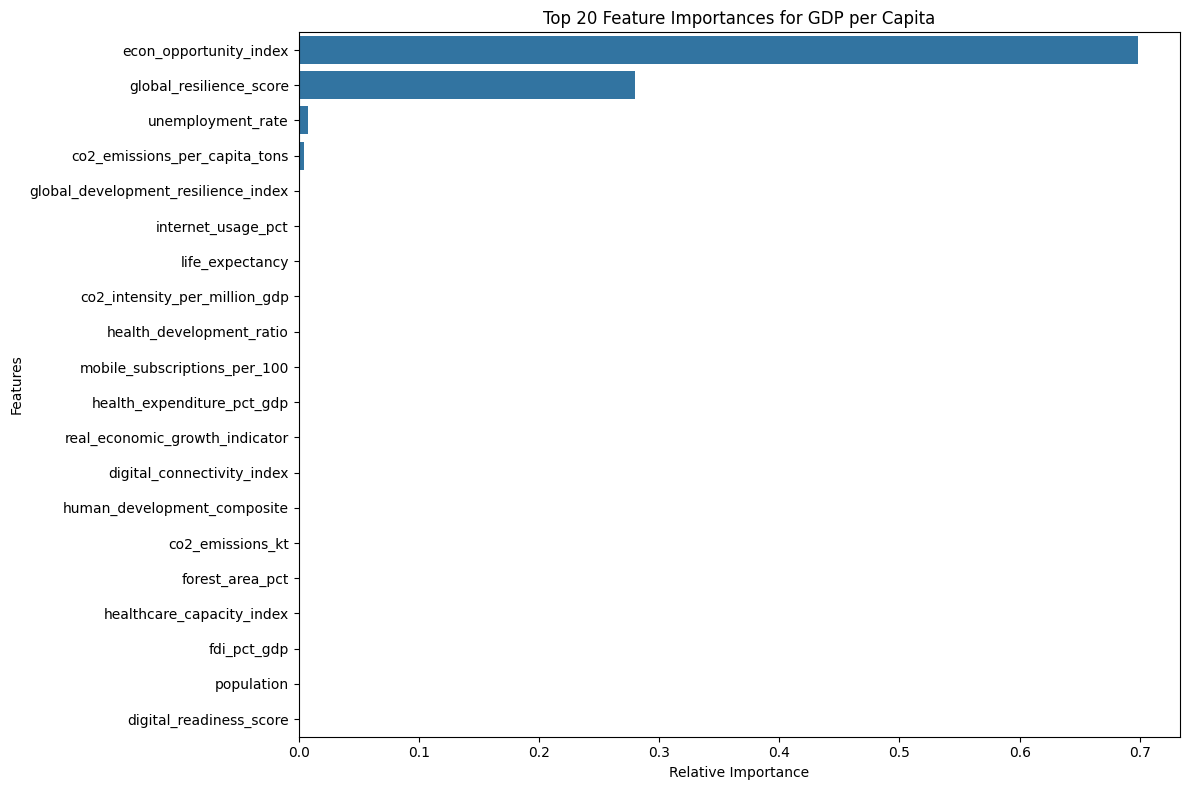

In [11]:
# Step 5: Fit Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance visualization
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = [features[i] for i in indices[:20]]

plt.figure(figsize=(12, 8))
sns.barplot(x=importances[indices[:20]], y=top_features)
plt.title("Top 20 Feature Importances for GDP per Capita")
plt.xlabel("Relative Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [12]:
# Step 6: Statistical significance via OLS
# Add constant for intercept
X_ols = sm.add_constant(X_scaled)
ols_model = sm.OLS(y, X_ols).fit()
summary = ols_model.summary()
print(summary)

# Show statistically significant features (p < 0.05)
significant_features = pd.Series(ols_model.pvalues, index=['Intercept'] + features)
significant_features = significant_features[significant_features < 0.05]
print("\nStatistically significant features (p < 0.05):")
print(significant_features.drop('Intercept', errors='ignore'))

                            OLS Regression Results                            
Dep. Variable:         gdp_per_capita   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.792e+12
Date:                Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                        18:34:43   Log-Likelihood:                 4482.0
No. Observations:                3653   AIC:                            -8908.
Df Residuals:                    3625   BIC:                            -8734.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.153e+04      0.001   9.78e+06      0.0